# Box Office Prediction

Denne oppgaven skal i all hovedsak forutse omsetning til en film når den lanseres. Kalkulasjonene baseres på data som kommer fra TMDB. Det er ulike attributter å ta hensyn til når det kommer til å forutse hvor mye omsetning en filmproduksjon kommer til å ha, og det er ved å ta et dypdypp i disse faktorene, vi håper å ende opp med en god kalkulasjon.

### Importerer nødvendige libraries

In [802]:
import pandas as pd
import numpy as np

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('dark_background')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from collections import OrderedDict

# data
import os
print(os.listdir("data2"))

# Importerer warnings slik at vi kan ignorere en advarsel som ikke har betydning for denne oppgaven
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

['sample_submission.csv', 'test.csv', 'train.csv']


In [803]:
#Reads in the csv-files and creates a dataframe using pandas

train = pd.read_csv('data2/train.csv')
test = pd.read_csv('data2/test.csv')
sampleSubmission = pd.read_csv('data2/sample_submission.csv')

In [804]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


Starter med å få en oversikt over attributtene samt de øverste radene

In [805]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [806]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

info-metoden gir oss en oversikt over aktuelle attributter, og for å få en bedre forståelse for attributten vi skal arbeide med, definerer vi de:

id: En unik integrer for hver film <br>
belongs_to_collection: Inneholder id fra The Movie Database(TMDB), film plakater og URL til en film <br>
budget: Budsjettet til filmen i dollar <br>
genres: Inneholder sjanger og id til filmen i TMDB <br>
homepage: Offisiell link til filmen <br>
imdb_id: IMDB id lagret som en String <br>
original_language: Originalspråket til filmen som en to-sifret kode, f. eks EN for engelsk <br>
orginal_title: Tittelen til filmen i originalspråket <br>
overview: En kort beskrivelse av innholdet til filmen <br>
popularity: Filmens popularitet <br>
poster_path: En path til fullversjon av plakaten <br>
production_companies: Inneholder navn på produksjonensselskapet til filmen, samt korresponderende TMDB id <br>
production_countries: Navn til produksjonslandet og en to-sifret id <br>
release_date: Lanseringsdato for filmen i formatet mm/dd/åå <br>
runtime: Lengde på film i minutter <br>
spoken_languages: Språket til filmen, samt en to-sifret kode <br>
status: Er filmen lansert eller er det ryktet at filmen skal lanseres? <br>
tagline: Slagord for filmen <br>
title: Den engelske tittelen på filmen <br>
keywords: Inneholder alle søkeord til filmen samt TMDB id <br>
cast: Inneholder rollebesettninges TMDB id, navn, karakter navn og kjønn <br>
crew: Inneholder navn, TMDB id og jobbtittel <br>
revenue: Filmens inntekter i dollar

In [807]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

Som forventet har testsettet en mindre attributt, nemlig revenue.

In [808]:
train.shape, test.shape
print('Antall filmer i treningssettet er',train.shape[0],
     'og antall filmer i testsettet er', test.shape[0])

((3000, 23), (4398, 22))

Antall filmer i treningssettet er 3000 og antall filmer i testsettet er 4398


In [809]:
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt2637294,en,Joshua,"When Lou, who has become the ""father of the In...",NaN,...,9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,The Magnificent Seven,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '59ac067c92514107af02c8c8', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


In [810]:
test.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
count,4398.000000,877,4.398000e+03,4382,1420,4398,4398,4398,4384,4398.000000,...,4296,4397,4394.000000,4356,4396,3535,4395,4005,4385,4376
unique,NaN,556,NaN,1101,1402,4398,39,4353,4383,NaN,...,458,3289,NaN,526,3,3529,4342,3885,4365,4376
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.thehungergames.movie/,tt1226251,en,Taxi,No overview found.,NaN,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",9/9/11,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What could go wrong?,Julia,"[{'id': 187056, 'name': 'woman director'}]",[],"[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
freq,NaN,10,NaN,348,3,1,3776,2,2,NaN,...,2587,7,NaN,2704,4389,2,2,30,21,1
mean,5199.500000,NaN,2.264929e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.550230,...,NaN,NaN,107.622212,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1269.737571,NaN,3.689991e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.209014,...,NaN,NaN,21.058290,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3001.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4100.250000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,3.895186,...,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5199.500000,NaN,7.450000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.482242,...,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,6298.750000,NaN,2.800000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.938524,...,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ved å bruke describe får vi en oppsummering av de numeriske attributtene. Vi får også nyttige verdier slik som gjennomsnitt, min, max og std (standard deviation).

Nå har vi blitt litt kjent med test- og treningssettet vårt, og vi ser at testsettet inneholder flere verdier (ca. 1/3 mer), noe som gir et godt utgangspunkt for å løse denne oppgaven.

## Gjennomgang av data

Vi ønsker å sjekke hvilke attributter som mangler verdier, ved å finne antall null-verdier.

In [811]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [812]:
test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

Vi ser at det er flere attributter som mangler verdier. Dette vet vi at vi er nødt til å gjøre noe med, og derfor tar vi en nærmere titt på attributtene som har null-verdier.

## Rensing av data

#### SPRÅK

Text(0.5, 1.0, 'Original Language and Revenue')

Text(0.5, 0, 'Revenue')

Text(0, 0.5, 'Original Language')

<AxesSubplot:title={'center':'Original Language and Revenue'}, xlabel='revenue', ylabel='original_language'>

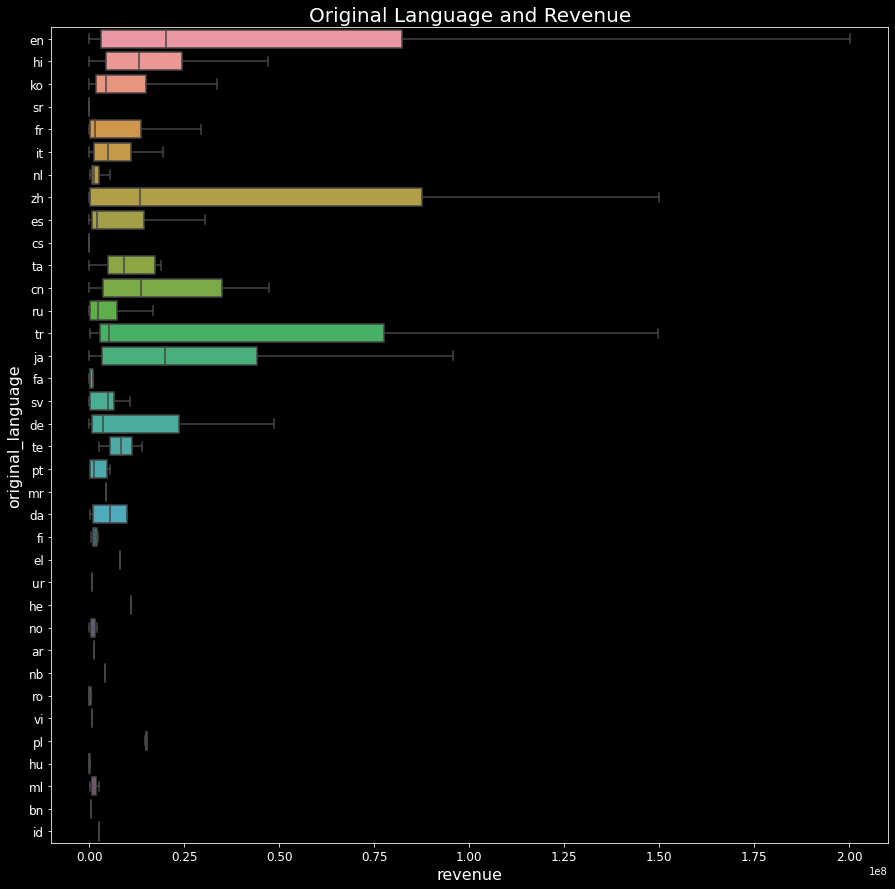

In [813]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', labelsize=12)
plt.title('Original Language and Revenue', fontsize=20)
plt.xlabel('Revenue', fontsize=16)
plt.ylabel('Original Language', fontsize=16)
sns.boxplot(ax=ax, x='revenue', y='original_language', data=train, showfliers=False, orient='h')
plt.show()

Her ser vi at noen språk generer mer omsetning enn andre, de mest merkbare er engelsk, kinesisk og tyrkisk.

<Figure size 1080x792 with 0 Axes>

Text(0.5, 1.0, 'Omsetning basert på språk')

[Text(0, 0, 'en'),
 Text(1, 0, 'hi'),
 Text(2, 0, 'ko'),
 Text(3, 0, 'fr'),
 Text(4, 0, 'it'),
 Text(5, 0, 'zh'),
 Text(6, 0, 'es'),
 Text(7, 0, 'cn'),
 Text(8, 0, 'ru'),
 Text(9, 0, 'ja')]

Text(0.5, 0, 'Språk')

Text(0, 0.5, 'Omsetning')

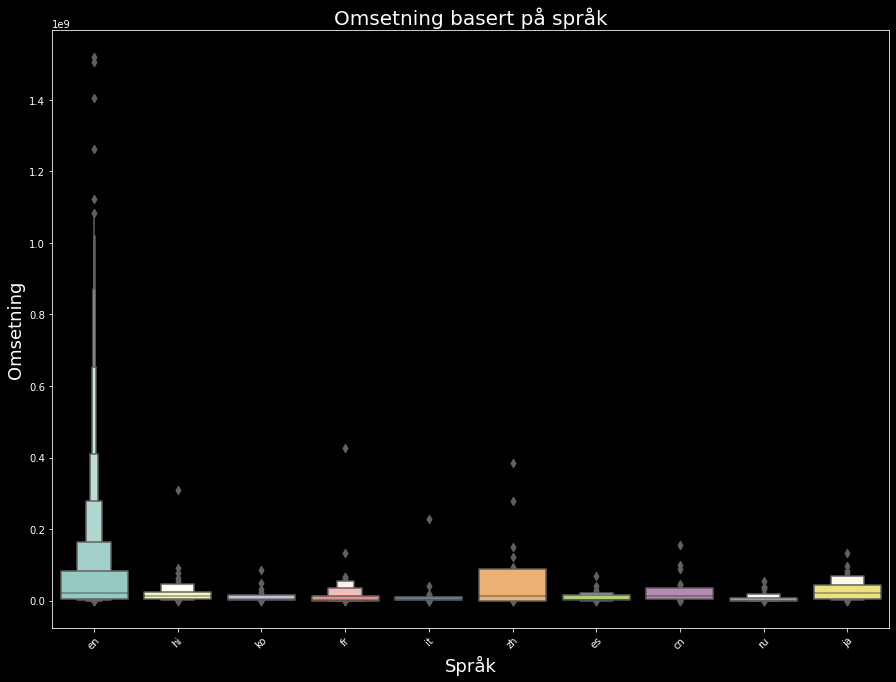

In [814]:
# Påvirkningsgrad av språk knyttet til omsetning
plt.figure(figsize=(15,11)) #figure size

g1 = sns.boxenplot(x='original_language', y='revenue', 
                   data=train[(train['original_language'].isin((train['original_language'].sort_values().value_counts()[:10].index.values)))])
g1.set_title("Omsetning basert på språk", fontsize=20) 
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel('Språk', fontsize=18)
g1.set_ylabel('Omsetning', fontsize=18)

plt.show()

Ved hjelp av dette blir det enda tydeligere hvilke språk som kan ha en innvirkning på omsetningen til en film, og vi velger derfor å ta med engelsk og kinesisk videre inn i modellen.

In [815]:
train['original_language'] = train['original_language'].apply(lambda x: 1 if x=='en' else(2 if x=='zh' else 0))
test['original_language'] = test['original_language'].apply(lambda x: 1 if x=='en' else(2 if x=='zh' else 0))

#### SJANGER

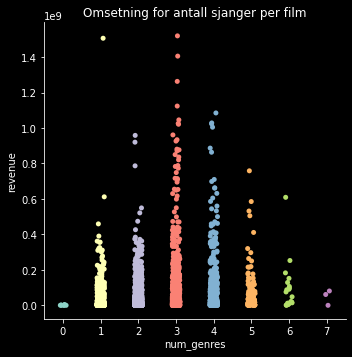

In [816]:
genres_count=[]
for i in train['genres']:
    if(not(pd.isnull(i))):
        
        genres_count.append(len(eval(i)))
        
    else:
        genres_count.append(0)
train['num_genres'] = genres_count

#Genres v/s revenue
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Omsetning for antall sjanger per film');

Da sjanger er en objekt-variabel, ønsker vi å gjøre denne numerisk. Vi velger derfor å se på antall sjangre per film, og knytter dette opp mot omsetning. 

In [817]:
genres_count_test=[]
for i in test['genres']:
    if(not(pd.isnull(i))):
        
        genres_count_test.append(len(eval(i)))
        
    else:
        genres_count_test.append(0)
test['num_genres'] = genres_count_test

Legger antall sjangere i testsettet vårt.

In [818]:
train.drop(['genres'],axis=1, inplace = True)
test.drop(['genres'],axis=1, inplace = True)

Dropper den originale sjanger attributten.

#### PRODUKSJONSSELSKAP

Text(0.5, 1.0, 'Inntekt for antall produksjons selskaper i filmene')

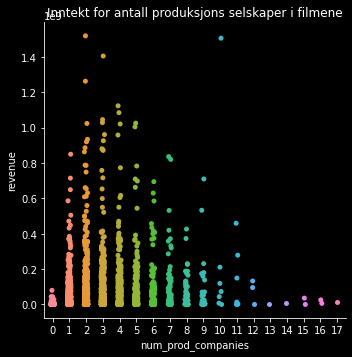

In [819]:
prod_comp_count=[]
for i in train['production_companies']:
    if(not(pd.isnull(i))):
        
        prod_comp_count.append(len(eval(i)))
        
    else:
        prod_comp_count.append(0)
train['num_prod_companies'] = prod_comp_count

sns.catplot(x='num_prod_companies', y='revenue', data=train)
plt.title('Inntekt for antall produksjons selskaper i filmene')

På lik måte som sjanger er produksjonsselskap også en objekt-variabel. Det blir derfor samme fremgangsmåte - vi sammenligner antall produksjonsselskap med omsetning til en film. 

In [820]:
#Adding production_companies count for  test data
prod_comp_count_test=[]
for i in test['production_companies']:
    if(not(pd.isnull(i))):
        
        prod_comp_count_test.append(len(eval(i)))
        
    else:
        prod_comp_count_test.append(0)
test['num_prod_companies'] = prod_comp_count_test

Legger antall produksjonsselskap til i testsettet vårt.

Nå som vi har en oversikt kan vi droppe de gamle variablene.

In [821]:
train.drop(['production_companies'],axis=1, inplace = True)
test.drop(['production_companies'],axis=1, inplace = True)

#### PRODUKSJONSLAND

Det er samme fremgangsmåte som de tidligere nevnte attributtene

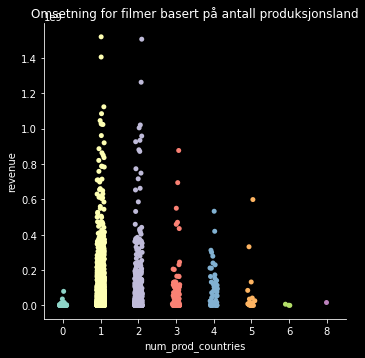

In [822]:
prod_coun_count=[]
for i in train['production_countries']:
    if(not(pd.isnull(i))):
        
        prod_coun_count.append(len(eval(i)))
        
    else:
        prod_coun_count.append(0)
train['num_prod_countries'] = prod_coun_count

#number of prod countries vs revenue
sns.catplot(x='num_prod_countries', y='revenue', data=train);
plt.title('Omsetning for filmer basert på antall produksjonsland');

In [823]:
prod_coun_count_test=[]
for i in test['production_countries']:
    if(not(pd.isnull(i))):
        
        prod_coun_count_test.append(len(eval(i)))
        
    else:
        prod_coun_count_test.append(0)
test['num_prod_countries'] = prod_coun_count_test

In [824]:
train.drop(['production_countries'],axis=1, inplace = True)
test.drop(['production_countries'],axis=1, inplace = True)

#### HOMEPAGE

Homepage er en av variablene med flest null-verdier.

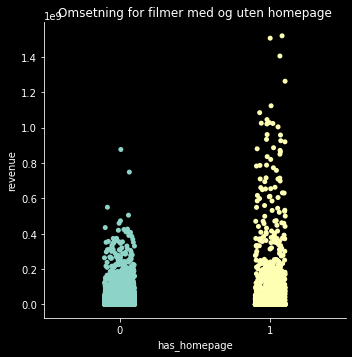

In [825]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Omsetning for filmer med og uten homepage');

Velger å gjøre attributten om til binære tall - har du homepage = 1, har du ikke = 0. Sammenligner dette med omsetning, og ser at dette vil ha svært liten påvirkningsgrad til hvor god omsetning en film vil ha.

In [826]:
train = train.drop(['homepage'],axis =1)
test = test.drop(['homepage'],axis =1)

Dropper derfor homepage, da det virker urelevant for datasettet. 

#### COLLECTIONS

Her kjører vi samme fremgangsmåte som med homepage - vi gjør dataene om til binært.

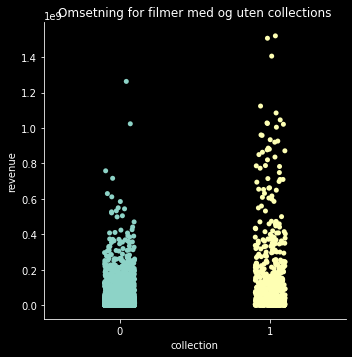

In [827]:
train['collection'] = 0
train.loc[train['belongs_to_collection'].isnull() == False, 'collection'] = 1
test['collection'] = 0
test.loc[test['belongs_to_collection'].isnull() == False, 'collection'] = 1

sns.catplot(x='collection', y='revenue', data=train);
plt.title('Omsetning for filmer med og uten collections');

Tolker utfallet, og ser at det igjen ikke vil ha særlig stor innvirkning på kalkulasjonene. Dropper attributten.

In [828]:
train=train.drop(['belongs_to_collection'],axis =1)
test=test.drop(['belongs_to_collection'],axis =1)

Dropper der denne ikke kommer til å utvirke noen forskjell for oss

#### BESKRIVELSE

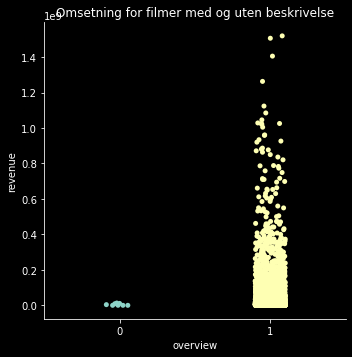

In [829]:
train['overview']=train['overview'].apply(lambda x: 0 if pd.isnull(x) else 1)
test['overview']=test['overview'].apply(lambda x: 0 if pd.isnull(x) else 1)
sns.catplot(x='overview', y='revenue', data=train);
plt.title('Omsetning for filmer med og uten beskrivelse');

In [830]:
train = train.drop(['overview'],axis=1)
test = test.drop(['overview'],axis=1)

Som de to tidligere attributtene sitter vi igjen med samme konklusjon, og vi tar altså ikke med oss overview-attributten med videre. 

#### ROLLEBESETNING

Fremfor å behandle dataene som hvilken rollebesetning som er med i en film, manipulerer vi de til å være antall rollebesetninger per film. Dette gjør vi for både test- og treningssettet vårt.

In [831]:
total_cast=[]
for i in train['cast']:
    if(not(pd.isnull(i))):
        
        total_cast.append(len(eval(i)))
        
    else:
        total_cast.append(0)
train['cast_count'] = total_cast

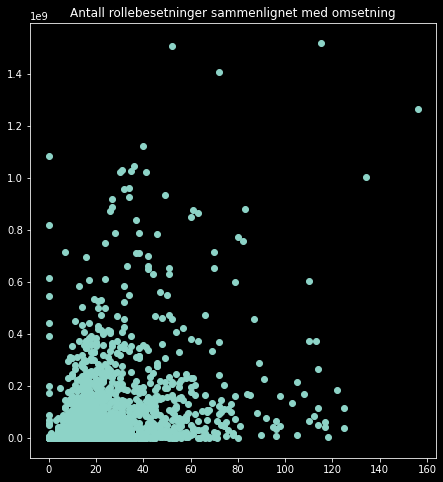

In [832]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['cast_count'], train['revenue'])
plt.title('Antall rollebesetninger sammenlignet med omsetning');

In [833]:
total_cast=[]
for i in test['cast']:
    if(not(pd.isnull(i))):
        
        total_cast.append(len(eval(i)))
        
    else:
        total_cast.append(0)
test['cast_count'] = total_cast

In [834]:
train = train.drop(['cast'],axis=1)
test = test.drop(['cast'],axis=1)

Dropper den opprinnelige cast-attributten.

#### CREW

Denne attributten blir modifisert på samme måte som rollebesetning. Same same...

In [835]:
total_crew=[]
for i in train['crew']:
    if(not(pd.isnull(i))):
        
        total_crew.append(len(eval(i)))
        
    else:
        total_crew.append(0)
train['crew_count'] = total_crew

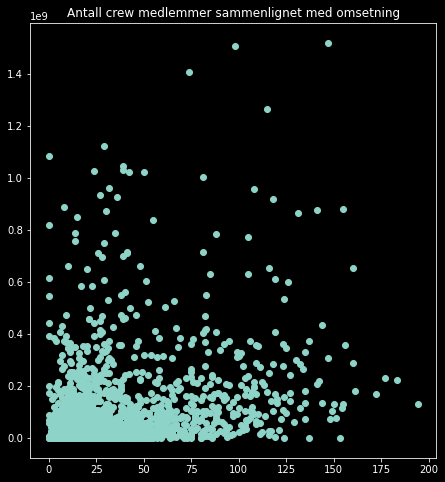

In [836]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['crew_count'], train['revenue'])
plt.title('Antall crew medlemmer sammenlignet med omsetning');

In [837]:
total_crew=[]
for i in test['crew']:
    if(not(pd.isnull(i))):
        
        total_crew.append(len(eval(i)))
        
    else:
        total_crew.append(0)
test['crew_count'] = total_crew

In [838]:
train = train.drop(['crew'],axis=1)
test = test.drop(['crew'],axis=1)

#### NØKKELORD

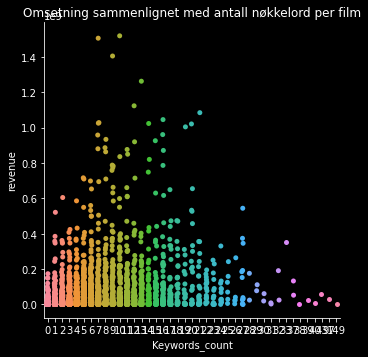

In [839]:
Keywords_count=[]
for i in train['Keywords']:
    if(not(pd.isnull(i))):
        
        Keywords_count.append(len(eval(i)))
        
    else:
        Keywords_count.append(0)
train['Keywords_count'] = Keywords_count

sns.catplot(x='Keywords_count', y='revenue', data=train);
plt.title('Omsetning sammenlignet med antall nøkkelord per film');

Vi mener det er bedre med en tellefunksjon over antall nøkkelord per film, fremfor å sammenligne med nøkkelordene.

In [840]:
Keywords_count=[]
for i in test['Keywords']:
    if(not(pd.isnull(i))):
        
        Keywords_count.append(len(eval(i)))
        
    else:
        Keywords_count.append(0)
test['Keywords_count'] = Keywords_count

In [841]:
train = train.drop(['Keywords'],axis=1)
train = train.drop(['title'],axis=1)
test = test.drop(['Keywords'],axis=1)
test = test.drop(['title'],axis=1)

Dropper nøkkelord og tittel på film.

#### SPILLETID

Spilletid har to null-verdier, løser dette problemet ved å gjøre dette om til gjennomsnittlig spilletid. De som mangler verdier fyller vi inn 0 fremfor null.

In [842]:
train['runtime'] = train['runtime'].fillna(train['runtime'].mean())
test['runtime'] = test['runtime'].fillna(test['runtime'].mean())

#### SPRÅK

In [843]:
spoken_count=[]
for i in train['spoken_languages']:
    if(not(pd.isnull(i))):
        
        spoken_count.append(len(eval(i)))
        
    else:
        spoken_count.append(0)
train['spoken_count'] = spoken_count


spoken_count_test=[]
for i in test['spoken_languages']:
    if(not(pd.isnull(i))):
        
        spoken_count_test.append(len(eval(i)))
        
    else:
        spoken_count_test.append(0)
test['spoken_count'] = spoken_count_test

Dropper den originale språk-attributten, da dette er en objekt-variabel.

In [844]:
train.drop(['spoken_languages'],axis=1,inplace=True)
test.drop(['spoken_languages'],axis=1,inplace=True)

### KORRELASJON

Nå som vi har renset mesteparten av dataen ved å fjerne null-verdier og gjøre om de fleste objekt-variabler til int-variabler, kan vi se nærmere på korrelasjon mellom relevante attributter.

(<Figure size 720x576 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

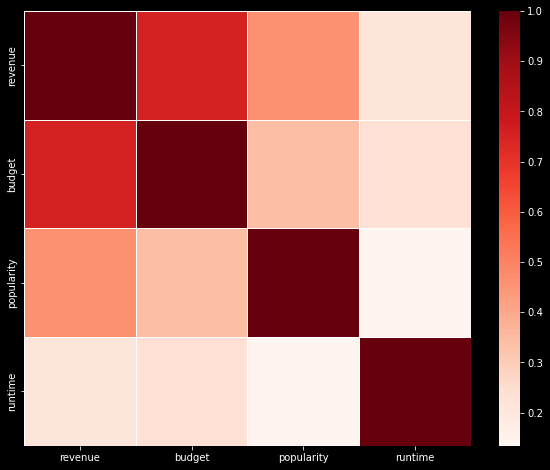

In [845]:
col = ['revenue','budget','popularity','runtime']

plt.subplots(figsize=(10, 8))

corr = train[col].corr()

sns.heatmap(corr, xticklabels=col,yticklabels=col, linewidths=.5, cmap="Reds")

Plotter en visualisjon som tar for seg de variablene vi tenker er mest relevant, som er budsjett, omsetning, popularitet og spilletid. Vi merker oss at budsjett og omsetning har stor korrelasjon, og vil derfor ta en nærmere titt på dette nå.

<AxesSubplot:xlabel='budget', ylabel='revenue'>

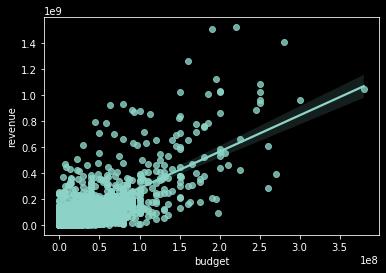

In [846]:
sns.regplot(x="budget", y="revenue", data = train)

Vi ser at jo høyere budsjett som regel tilsvarer høyere omsetning.

In [847]:
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

Deretter ønsker vi å se på korrelasjon mellom utgivelsesdag og omsetning. I utgangspunktet kan vi ikke bruke den opprinnelige release_day attributten, ettersom noen av dataene ble tolket som fremtidige datoer.

<AxesSubplot:xlabel='release_date', ylabel='revenue'>

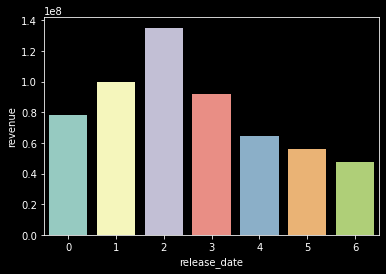

In [848]:
release_day = train['release_date'].value_counts().sort_index()
release_day_revenue = train.groupby(['release_date'])['revenue'].sum()
release_day_revenue.index = release_day_revenue.index.dayofweek
sns.barplot(release_day_revenue.index,release_day_revenue, data = train,ci=None)
plt.show()

In [849]:
train['release_day'] = train['release_date'].dt.dayofweek 
test['release_day'] = test['release_date'].dt.dayofweek 

Legger til den modifiserte release_day attributten til test- og treningssettet vårt. Fyller deretter inn nuller der det trengs (i null-verdier) (null = 0).

In [850]:
test['release_day'] = test['release_day'].fillna(0)

In [851]:
train.drop(['release_date'],axis=1,inplace=True)
test.drop(['release_date'],axis=1,inplace=True)

Dropper så release_day da denne nå er irrelevant.

In [852]:
print("train data")
print(train['status'].value_counts())
print("test data")
test['status'].value_counts()

train data
Released    2996
Rumored        4
Name: status, dtype: int64
test data


Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

In [853]:
train.drop(['status'],axis=1,inplace =True)
test.drop(['status'],axis=1,inplace =True)

Etter å ha undersøkt status til filmen, konkluderer vi med at denne attributten heller ikke er relevant, og dropper derfor denne.

In [854]:
train.drop(['imdb_id','poster_path', 'original_title', 'tagline'],axis=1,inplace=True)
test.drop(['imdb_id','poster_path', 'original_title', 'tagline'],axis=1,inplace=True)

Til sist fjerner vi alle irrelevante attributter.

#### EN SISTE SJEKK

In [855]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3000 non-null   int64  
 1   budget              3000 non-null   int64  
 2   original_language   3000 non-null   int64  
 3   popularity          3000 non-null   float64
 4   runtime             3000 non-null   float64
 5   revenue             3000 non-null   int64  
 6   num_genres          3000 non-null   int64  
 7   num_prod_companies  3000 non-null   int64  
 8   num_prod_countries  3000 non-null   int64  
 9   has_homepage        3000 non-null   int64  
 10  collection          3000 non-null   int64  
 11  cast_count          3000 non-null   int64  
 12  crew_count          3000 non-null   int64  
 13  Keywords_count      3000 non-null   int64  
 14  spoken_count        3000 non-null   int64  
 15  release_day         3000 non-null   int64  
dtypes: flo

In [856]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3000 non-null   int64  
 1   budget              3000 non-null   int64  
 2   original_language   3000 non-null   int64  
 3   popularity          3000 non-null   float64
 4   runtime             3000 non-null   float64
 5   revenue             3000 non-null   int64  
 6   num_genres          3000 non-null   int64  
 7   num_prod_companies  3000 non-null   int64  
 8   num_prod_countries  3000 non-null   int64  
 9   has_homepage        3000 non-null   int64  
 10  collection          3000 non-null   int64  
 11  cast_count          3000 non-null   int64  
 12  crew_count          3000 non-null   int64  
 13  Keywords_count      3000 non-null   int64  
 14  spoken_count        3000 non-null   int64  
 15  release_day         3000 non-null   int64  
dtypes: flo

Får en ny oversikt over null-verdiene og datatypene til attributtene våre, og er strålende fornøyd med egen innsats. Ser at ingen attributter nå har null-verdier, og det er ikke lenger objekter som datatyper.

### Trening av modellen

In [857]:
train['budget'] = np.log1p(train['budget'])
test['budget'] = np.log1p(test['budget'])

In [858]:
y= train['revenue'].values
cols = [col for col in train.columns if col not in ['revenue', 'id']]
X= train[cols].values
y = np.log1p(y)

##### LINEÆR REGRESJON

In [859]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
scores = cross_val_score(clf, X, y, scoring="neg_mean_squared_error", cv = 8)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

2.443407870789952


##### RANDOM FOREST GENERATOR

In [860]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=10, min_samples_split=5, random_state = 10,
                             n_estimators=500)
scores = cross_val_score(regr, X, y, scoring="neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

2.21926471526332


Nå skal vi teste modellen

In [861]:
cols = [col for col in test.columns if col not in ['id']]
X_test= test[cols].values

In [862]:
regr.fit(X,y)
y_pred = regr.predict(X_test)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=500,
                      random_state=10)

In [863]:
y_pred=np.expm1(y_pred)
pd.DataFrame({'id': test.id, 'revenue': y_pred}).to_csv('submission_RF.csv', index=False)

Dette gikk fint.